# Fuctions and setup

In [3]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d import Axes3D
print(qt.__version__)

5.0.4


In [4]:
def create_thermal_state(N,J,h,beta):

    H = 0

    for i in range(N - 1):
        ops = [qt.qeye(2)] * N  # start with all identities
        ops[i] = qt.sigmaz()    # put σ_z at position i
        ops[i + 1] = qt.sigmaz()  # put σ_z at position i+1
        H += -J * qt.tensor(ops)

    for i in range(N):
        ops = [qt.qeye(2)] * N
        ops[i] = qt.sigmax()
        H += -h * qt.tensor(ops)

    rho_thermal = (-beta * H).expm()
    rho_thermal /= rho_thermal.tr()  # normalization

    return rho_thermal

def force_diagonal(rho, threshold=1e-10):
    rho_matrix = rho.full()  # Convert to numpy array
    rho_diag = np.diag(np.diag(rho_matrix))  # Keep diagonal only
    rho_diag[np.abs(rho_diag) < threshold] = 0.0  # Threshold small elements
    rho_diag /= np.trace(rho_diag)  # Re-normalize
    return qt.Qobj(rho_diag, dims=rho.dims)

def corr_length(h,J):
    return 1/(np.abs(np.log(h/J)))

def generate_partitions(n):
    assert n % 2 == 1, "n must be odd"
    
    partitions = []
    half = (n - 1) // 2
    a = list(range(0, half))
    c = [half]
    b = list(range(half + 1, n))
    
    # Store initial partition
    partitions.append({"a": a[:], "c": c[:], "b": b[:]})
    
    toggle = True  # True: move from a → c, False: b → c
    
    while len(a) > 1 or len(b) > 1:
        if toggle and len(a) > 1:
            # Move largest from a to front of c
            c.insert(0, a.pop())
        elif not toggle and len(b) > 1:
            # Move smallest from b to end of c
            c.append(b.pop(0))
        toggle = not toggle
        partitions.append({"a": a[:], "c": c[:], "b": b[:]})
    
    return partitions



# 1) first we check I(A:B)(N,1,0)

### For this quantity I've found the analytic expression: 
$$I(A\!:\!B)_{N,1,0} = \frac{1}{2\cosh(\beta J)} \left[ 
e^{\beta J} \log\left( \frac{e^{\beta J}}{\cosh(\beta J)} \right) 
+ 
e^{-\beta J} \log\left( \frac{e^{-\beta J}}{\cosh(\beta J)} \right) 
\right]$$

### we then confront this with a simulated chain for different values of the parameters

In [9]:
b_max = 10
b_min = 0.1
n = 8
J = 1
h = 0
a, b = np.split(np.arange(n ), [ (n ) // 2 ])
I_sim = np.zeros(10)
I_an = np.zeros(10)

j = 0

for beta in np.linspace(b_min,b_max,10):
    p = 0
    p = create_thermal_state(n,J,h,beta)

    # need to create the separation:
    
    p_A = p.ptrace(a)
    p_B = p.ptrace(b)
    I_sim[j] = qt.entropy_vn(p_A, base=2) + qt.entropy_vn(p_B, base=2) - qt.entropy_vn(p, base=2)
    I_an[j] = (1 / (2 * np.cosh(beta * J))) * (np.exp(beta * J) * np.log2(np.exp(beta * J) / np.cosh(beta * J)) +
                                                np.exp(-beta * J) * np.log2(np.exp(-beta * J) / np.cosh(beta * J)))
    j +=1


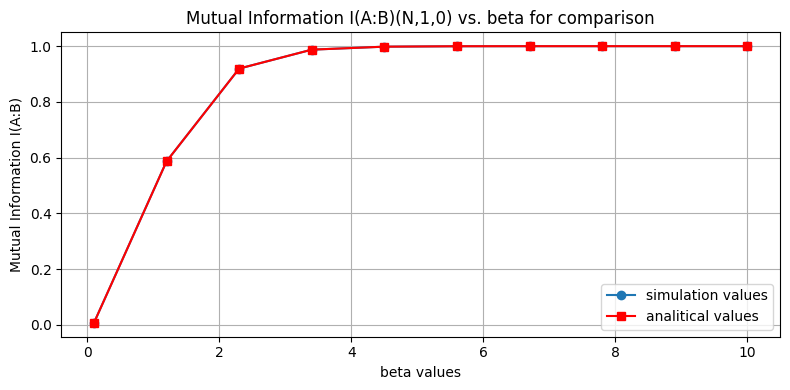

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(np.linspace(b_min,b_max,10),I_sim,marker='o', label = 'simulation values')
plt.plot(np.linspace(b_min,b_max,10),I_an,marker='s',color = 'red', label = 'analitical values')
plt.xlabel('beta values')
plt.ylabel('Mutual Information I(A:B)')
plt.title('Mutual Information I(A:B)(N,1,0) vs. beta for comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### ence a perfect agreement!

# 2) Check that in Classical Ising model:
$$I(A:B|C) = 0 \quad \forall C$$

$$I(A:B|C) = \sum_{{x}}{p_{ABC}log\left(\frac{p_{ABC}p_c}{p_{AC}p_{BC}}\right)}=0$$

#  3) Check That I(A:B)(N,1,l) behave as the simulation.

### the analitical calculations yelds: 
$$I(A:B)_{N,1,l} = \frac{1 + \left( \tanh(\beta J) \right)^{l+1}}{2} \log \left[ 1 + \left( \tanh(\beta J) \right)^{l+1} \right] + \frac{1 - \left( \tanh(\beta J) \right)^{l+1}}{2} \log \left[ 1 - \left( \tanh(\beta J) \right)^{l+1} \right]
$$

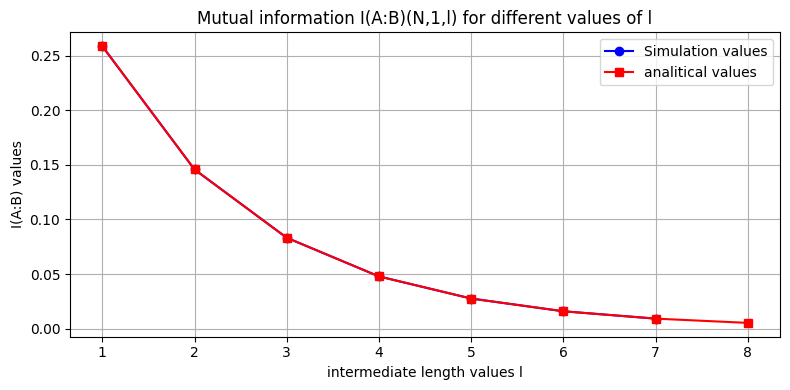

In [17]:

n = 9
J = 1
beta = 1
h = 0
max_l = 10 

c_range = list(range(1, n -1))
partitions = generate_partitions(n)
I_ABsC = np.zeros(len(c_range))


for idx, part in enumerate(partitions):
    a = part["a"]
    c = part["c"]
    b = part["b"]
    
    p = create_thermal_state(n, J, h, beta)
    p_A = p.ptrace(a)
    p_B = p.ptrace(b)
    p_AB = p.ptrace(a+b)
    

    I_ABsC[idx] = qt.entropy_vn(p_A, base=2) + qt.entropy_vn(p_B, base=2) - qt.entropy_vn(p_AB, base=2) 
    

def expectation_log_function(beta, J, max_l):
    l_values = np.arange(1, max_l+1)
    tanh_beta_J = np.tanh(beta * J)
    tanh_power_l = tanh_beta_J ** (l_values+1)

    term_pos = 0.5 * (1 + tanh_power_l) * np.log2(1 + tanh_power_l)
    term_neg = 0.5 * (1 - tanh_power_l) * np.log2(1 - tanh_power_l)

    expectation = (term_pos + term_neg)

    return l_values, expectation

 
l_values, expectation_values = expectation_log_function(beta, J, n-1)

plt.figure(figsize=(8, 4))
plt.plot(c_range, I_ABsC,linestyle='-', marker='o', color = 'blue', label = 'Simulation values')
plt.plot(l_values, expectation_values, marker = 's', color='red', label = 'analitical values')
plt.title("Mutual information I(A:B)(N,1,l) for different values of l")
plt.xlabel("intermediate length values l")
plt.ylabel("I(A:B) values")
plt.legend(loc='best') 
plt.grid(True)
plt.tight_layout()
plt.show()
